In [1]:
#Step 10 trains and tests both hospitals on the testing data using random forest and 10 fold nested cross validation. 

In [2]:
#Import the necessary modules. 
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.metrics import (
    precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, 
    roc_auc_score, precision_score, recall_score, accuracy_score
)
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
import seaborn as sns


In [3]:
# Load the testing CSV file into a DataFrame. 
df = pd.read_csv('test_data_.csv')

assert 122501769 not in df['BDSPPatientID'].values

#Remove the row where 'BDSPPatientID' is 122501769, as this patient was over 120 years old. 
#df = df[df['BDSPPatientID'] != 122501769]

#Save the DataFrame back to a CSV file. 
#df.to_csv('test_data_.csv', index=False)


In [9]:
#Assign the correct variables to test the data. 
matrix = pd.read_csv('test_data_.csv')
matrix = matrix.sample(random_state = 2023, frac = 1, ignore_index=True)  

#Drop the annotation (annot) column to create X_data. 
X_data = matrix.drop('annot', axis=1).reset_index(drop = True)

#Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre. 
y_data_pre = matrix[['BDSPPatientID', 'annot']].reset_index(drop = True)

assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)

y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y_holdout = y_data_pre['annot']
print(y_holdout)

X_data=X_data.drop(['annot'], axis=1)
X_holdout=X_data.drop(['BDSPPatientID', 'ContactDate', 'hospital', 'Unnamed: 0', 'NoteFileName', 'Site'], axis=1) 
print(X_holdout)
feature_names = X_holdout.columns.tolist()

      Unnamed: 0  BDSPPatientID ContactDate  \
0           1451      116551953  2017-04-12   
1           1625      150626794  2016-06-28   
2            921      111708750  2020-07-01   
3           2827      150293166  2013-11-24   
4           2675      150744963  2011-09-26   
...          ...            ...         ...   
1494        1806      150001850  2014-07-26   
1495        1048      115875112  2016-11-04   
1496        1406      115098587  2021-07-12   
1497         927      117157833  2021-03-29   
1498        1731      151195673  2015-04-27   

                                   NoteFileName   Site  CT  MRI  acut sdh_pos  \
0     Notes_13364499668_1918544682_20170412.txt    MGB   1    1             0   
1      Notes_1130485717_9766596953_20160628.txt  BIDMC   1    0             0   
2     Notes_13504793443_3523347700_20200701.txt    MGB   0    0             0   
3       Notes_1130151802_169903067_20131124.txt  BIDMC   0    0             0   
4      Notes_1130603513_143940

In [7]:
matrix

,Unnamed: 0,BDSPPatientID,ContactDate,NoteFileName,Site,CT,MRI,acut sdh_pos,brain injuri_pos,brain mri_pos,...,recent sdh_neg,resolv sdh_neg,known sdh_neg,history_sdh,ICD_I62.0,ICD_S06.5,ICD_432.1,ICD_852.2or3,annot,hospital
0,921,111708750,2020-07-01,Notes_13504793443_3523347700_20200701.txt,MGB,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MGB
1,1312,117939541,2022-03-05,Notes_13499464719_5529195776_20220305.txt,MGB,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MGB
2,677,111542435,2020-10-04,Notes_13513563416_4799570962_20201004.txt,MGB,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,MGB
3,1306,115439197,2020-02-13,Notes_13379986745_2804791498_20200213.txt,MGB,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,MGB
4,439,114577524,2022-06-04,Notes_13608547805_7616395601_20220604.txt,MGB,0,1,0,0,0,...,0,0,0,0,0,1,1,0,1,MGB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,476,117781604,2021-05-13,Notes_13568797284_4895239859_20210513.txt,MGB,0,1,0,0,0,...,0,0,0,0,1,1,1,0,0,MGB
345,410,120581786,2020-10-15,Notes_13546935330_6581987132_20201015.txt,MGB,1,1,0,0,0,...,0,0,0,0,0,1,1,1,1,MGB
346,420,114213537,2021-04-03,Notes_13537813334_6378102677_20210403.txt,MGB,1,1,1,0,0,...,0,0,0,0,0,1,1,0,1,MGB
347,1406,115098587,2021-07-12,Notes_13593120125_5465413296_20210712.txt,MGB,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,MGB


In [10]:
# get testing from new (>=2020)
# roughly COVID as the split point
# gap = 2 years since shifted day is within +/- 1 year

matrix['ContactDate'] = pd.to_datetime(matrix.ContactDate)
ids1 = matrix.ContactDate.dt.year<=2018
print(ids1.sum(), ids1.mean()*100)
print(matrix.annot[ids1].sum(), matrix.annot[ids1].mean()*100)

ids2 = matrix.ContactDate.dt.year>=2020
print(ids2.sum(), ids2.mean()*100)
print(matrix.annot[ids2].sum(), matrix.annot[ids2].mean()*100)

matrix = matrix[ids2].reset_index(drop=True)
X_data = X_data[ids2].reset_index(drop=True)
y_data = y_data[ids2].reset_index(drop=True)
y_data_pre = y_data_pre[ids2].reset_index(drop=True)
y_holdout = y_holdout[ids2].reset_index(drop=True)
X_holdout = X_holdout[ids2].reset_index(drop=True)

980 65.37691794529687
214 21.836734693877553
349 23.282188125416944
83 23.78223495702006


Accuracy: 0.9398 (95% CI: 0.9112 - 0.9599)
Precision: 0.8100 (95% CI: 0.7264 - 0.8738)
Recall (Sensitivity): 0.9759 (95% CI: 0.9350 - 1.0000)
F1 Score: 0.8852
AUC (ROC): 0.9712 (95% CI: 0.9553 - 0.9854)
AUC (PR): 0.8805 (95% CI: 0.8005 - 0.9420)
Specificity: 0.9286
False Positives: 19
False Negatives: 2


<Figure size 1200x600 with 0 Axes>

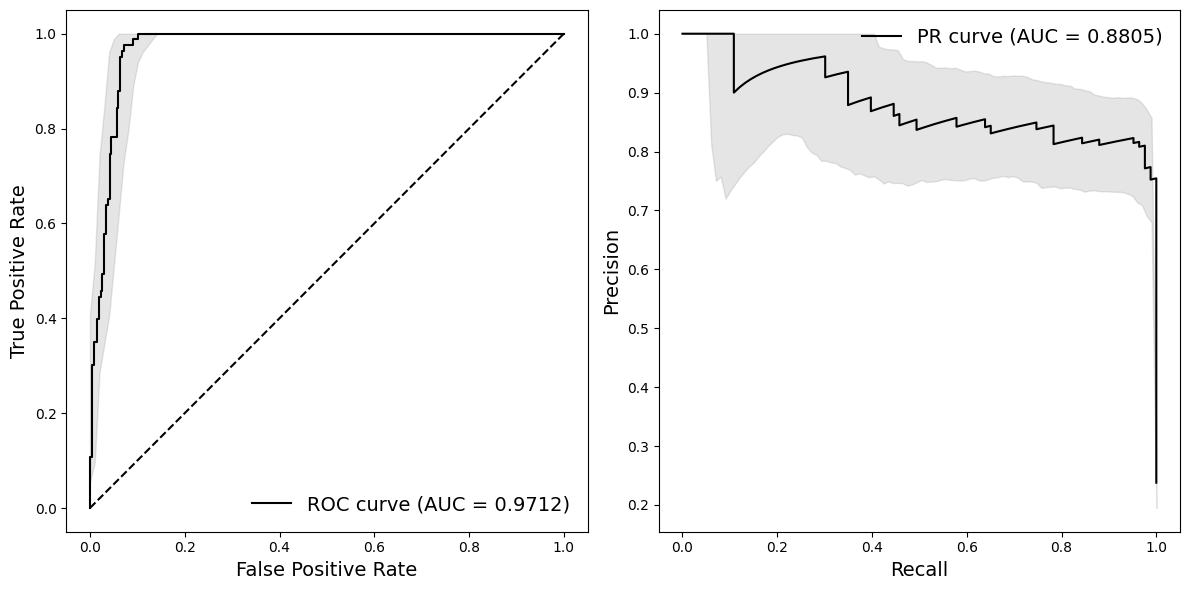

Number of False Positive Patient IDs: 19
Number of False Negative Patient IDs: 2


In [12]:
#Use random forest to conduct 10 fold nested cross validation. 

#Function to compute confidence intervals using bootstrapping. 
def bootstrap_ci(y_true, y_pred_proba, metric_func, num_bootstrap=1000, alpha=0.05):
    stats = []
    for _ in range(num_bootstrap):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_bs = y_true[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        stat = metric_func(y_true_bs, y_pred_proba_bs)
        stats.append(stat)
    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

# Function to compute ROC curve for bootstrapping
def bootstrap_roc_curves(y_true, y_pred_proba, num_bootstrap=1000):
    roc_curves = []
    for _ in range(num_bootstrap):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_bs = y_true[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        fpr, tpr, _ = roc_curve(y_true_bs, y_pred_proba_bs)
        roc_curves.append((fpr, tpr))
    return roc_curves

# Function to compute Precision-Recall curves for bootstrapping
def bootstrap_pr_curves(y_true, y_pred_proba, num_bootstrap=1000):
    pr_curves = []
    for _ in range(num_bootstrap):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_bs = y_true[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        precision, recall, _ = precision_recall_curve(y_true_bs, y_pred_proba_bs)
        pr_curves.append((precision, recall))
    return pr_curves

#Load the models and cutoffs. 
models = []
cutoffs = []
feature_importances_dict = {}

for fold in range(10):
    with open(f'RF_model_train_allhospitals_Notes+ICD+Med_fold{fold+1}_past.pickle', 'rb') as f:
        res = pickle.load(f)
    models.append(res['model'])
    cutoffs.append(res['cutoff'])
    
    #Extract the feature importances. 
    model = res['model']
    if hasattr(model, 'feature_importances_'):
        feature_importances_dict[fold] = model.feature_importances_

#Predict on the holdout set. 
y_pred_proba = np.zeros(X_holdout.shape[0])
y_pred = np.zeros(X_holdout.shape[0])

for model, cutoff in zip(models, cutoffs):
    yp_proba = model.predict_proba(X_holdout)[:, 1]
    y_pred_proba += yp_proba
    y_pred += (yp_proba > cutoff).astype(int)

#Calculate the average probability from the 10 folds based on majority vote. 
y_pred_proba /= len(models)
y_pred = (y_pred > (len(models) / 2)).astype(int)

roc_curves_bootstrap = bootstrap_roc_curves(y_holdout, y_pred_proba, num_bootstrap=1000)
pr_curves_bootstrap = bootstrap_pr_curves(y_holdout, y_pred_proba, num_bootstrap=1000)

#Calculate the metrics. 
fpr, tpr, _ = roc_curve(y_holdout, y_pred_proba)
auc_roc = roc_auc_score(y_holdout, y_pred_proba)
f1_holdout = f1_score(y_holdout, y_pred)
precision_holdout = precision_score(y_holdout, y_pred)
recall_holdout = recall_score(y_holdout, y_pred)
precision, recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)
accuracy = accuracy_score(y_holdout, y_pred)
cf_holdout = confusion_matrix(y_holdout, y_pred)

#Extract the false positives, false negatives, true positives, and true negatives. 
tn, fp, fn, tp = cf_holdout.ravel()

#Calculate specificity. 
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

#Compute the confidence intervals. 
accuracy_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: accuracy_score(y, (p > 0.5).astype(int)))
precision_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: precision_score(y, (p > 0.5).astype(int)))
recall_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: recall_score(y, (p > 0.5).astype(int)))
auc_roc_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: roc_auc_score(y, p))
auc_pr_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: auc(precision_recall_curve(y, p)[1], precision_recall_curve(y, p)[0]))

#Print the metrics. 
print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall (Sensitivity): {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f}")
print(f"AUC (ROC): {auc_roc:.4f} (95% CI: {auc_roc_ci[0]:.4f} - {auc_roc_ci[1]:.4f})")
print(f"AUC (PR): {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")
print(f"Specificity: {specificity:.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

#Plot the ROC Curve with Confidence Intervals. 
plt.figure(figsize=(12, 6))

#Plot the ROC Curve with Confidence Intervals. 
plt.figure(figsize=(12, 6))

#ROC Curve
plt.subplot(1, 2, 1)
main_fpr, main_tpr, _ = roc_curve(y_holdout, y_pred_proba)
main_auc = auc(main_fpr, main_tpr)

#Calculate confidence intervals for ROC. 
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

plt.plot(main_fpr, main_tpr, color='black', label=f'ROC curve (AUC = {main_auc:.4f})')
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='grey', alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(frameon=False, fontsize=14)  


#Plot the Precision-Recall Curve with Confidence Intervals. 
plt.subplot(1, 2, 2)
main_precision, main_recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
main_auc_pr = auc(main_recall, main_precision)

#Calculate confidence intervals for PR. 
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)

plt.plot(main_recall, main_precision, color='black', label=f'PR curve (AUC = {main_auc_pr:.4f})')
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='grey', alpha=0.2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(frameon=False, fontsize=14)  
plt.tight_layout()
plt.show()


#Extract patient IDs for false positives and false negatives.
#Ensure that the index of the DataFrame is properly aligned.
#Assuming matrix.BDSPPatientID is a pandas Series with correct alignment.
false_positive_ids = matrix.BDSPPatientID[(y_holdout == 0) & (y_pred == 1)]
false_negative_ids = matrix.BDSPPatientID[(y_holdout == 1) & (y_pred == 0)]

#Create DataFrames with patient IDs, annot (y_holdout), and y_pred.
false_positive_df = pd.DataFrame({
    'BDSPPatientID': false_positive_ids,
    'annot': y_holdout[(y_holdout == 0) & (y_pred == 1)],
    'y_pred': y_pred[(y_holdout == 0) & (y_pred == 1)]
})

false_negative_df = pd.DataFrame({
    'BDSPPatientID': false_negative_ids,
    'annot': y_holdout[(y_holdout == 1) & (y_pred == 0)],
    'y_pred': y_pred[(y_holdout == 1) & (y_pred == 0)]
})

#Print the number of false positive and false negative patient IDs.
print(f"Number of False Positive Patient IDs: {len(false_positive_df)}")
print(f"Number of False Negative Patient IDs: {len(false_negative_df)}")

#Save to CSV files. 
false_positive_df.to_csv("false_positive_ids.csv", index=False)
false_negative_df.to_csv("false_negative_ids.csv", index=False)
